## Решение задачи регрессии с помощью нейронных сетей

Определение стоимости недвижимости из набора данных [California Housing Data Set](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

Учебный курс "[Программирование глубоких нейронных сетей на Python](https://openedu.ru/course/urfu/PYDNN/)".

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
""" посмотрим, какие файлы храняться в директории """
import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dl-urfu-regression/sample_submission.csv
/kaggle/input/dl-urfu-regression/train.csv
/kaggle/input/dl-urfu-regression/test.csv


## Загружаем данные

In [42]:
train_df = pd.read_csv('/kaggle/input/dl-urfu-regression/train.csv')
test_df = pd.read_csv('/kaggle/input/dl-urfu-regression/test.csv')
sample_submission = pd.read_csv('/kaggle/input/dl-urfu-regression/sample_submission.csv', index_col='id')

**Описание данных**

California Housing содержит данные о средней стоимость домов в Калифорнии для квартала. Файл с данными содержит следующие столбцы:

*   **longitude** - долгота квартала с недвижимостью.
*   **latitude** - широта квартала с недвижимостью.
*   **housing_median_age** - медиана возраста домов в квартале.
*   **total_rooms** - общее колиичество комнат в квартале.
*   **total_bedrooms** - общее количество спален в квартале.
*   **population** - население квартала.
*   **households** - количество "домохозяйств" в квартале (групп людей живущих вместе в одном доме. Как правило это семьи).
*   **median_income** - медианный доход в квартале.
*   **median_house_value** - медианная стоимость дома в квартале.



In [43]:
"""Смотрим на случайные 3 записи в нашем тренировочном наборе"""
train_df.sample(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
15332,-122.20,37.78,52.0,2300.0,443.0,1225.0,423.0,3.5398,158400.0
3414,-118.23,33.99,5.0,706.0,203.0,839.0,199.0,4.5208,165000.0
11548,-121.48,38.52,34.0,2561.0,497.0,1583.0,530.0,3.1583,95800.0


In [44]:
"""Смотрим на случайные 3 записи в нашем тестовом наборе"""
test_df.sample(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
947,-118.26,34.12,52.0,1942.0,476.0,1375.0,477.0,2.7348
195,-117.17,34.51,15.0,5151.0,942.0,2896.0,897.0,3.4875
1880,-121.75,36.77,25.0,1851.0,418.0,1678.0,390.0,3.2937


In [45]:
"""Смотрим на случайные 3 записи в шаблоне для ответов"""
sample_submission.sample(3)

,median_house_value
id,
2429,0.2429
2806,0.2806
1562,0.1562


## Постановка задачи регрессии

Необходимо определить медианную стоимость дома в квартале, зная все остальные признаки.

**Целевая переменная**: `median_house_value`

**Признаки**: `longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households,	median_income`

Признаки подаются на вход нейронной сети, на выходе сеть должна выдать значение целевой переменной - `median_house_value`

In [46]:
"""Выделяем данные для обучения и преобразуем их в массивы numpy.
Функция pop() возвращает нам указанный столбец и одновременно удаляет его из таблицы.
Таким образом, когда мы присваиваем df_train в переменную x_train,
там уже нет столбца с метками правильных ответов median_house_value """
y_train = train_df.pop('median_house_value').values
x_train = train_df.values
x_test = test_df.values

In [47]:
"""Убедимся, что количество столбцов в данных совпадает"""
x_train.shape, x_test.shape

((17000, 8), (3000, 8))

**Стандартизация данных**

Вычитаем среднее значение и делим на стандартное отклонение

In [48]:
# Среднее значение
mean = x_train.mean(axis=0)
# Стандартное отклонение
std = x_train.std(axis=0)
x_train -= mean
x_train /= std
x_test -= mean
x_test /= std

## Создаем нейронную сеть

Выходной слой с одним линейным нейроном - для задачи регрессии функция активации - RELU.

In [49]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='relu'))

In [50]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               2304      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 44,513
Trainable params: 44,513
Non-trainable params: 0
_________________________________________________________________
None


**Компилируем сеть**

Функция ошибки - среднеквадратичное отклонение. Метрика - среднее абсолютное отклонение.

In [51]:
model.compile(optimizer='adam', loss='mape', metrics=['mae'])

## Обучаем нейронную сеть

In [53]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=225,
                    batch_size=25,
                    validation_split=0.1, 
                    verbose=2)

Epoch 1/225
612/612 - 1s - loss: 60.8025 - mae: 133928.9844 - val_loss: 34.4416 - val_mae: 78859.3047
Epoch 2/225
612/612 - 1s - loss: 28.3861 - mae: 59994.1211 - val_loss: 24.1208 - val_mae: 52759.2461
Epoch 3/225
612/612 - 1s - loss: 24.3459 - mae: 51421.7812 - val_loss: 22.8454 - val_mae: 49910.9844
Epoch 4/225
612/612 - 1s - loss: 23.4890 - mae: 49356.0234 - val_loss: 22.5224 - val_mae: 48819.5430
Epoch 5/225
612/612 - 1s - loss: 23.1763 - mae: 48542.4141 - val_loss: 22.3839 - val_mae: 47771.5625
Epoch 6/225
612/612 - 1s - loss: 22.9746 - mae: 48184.8359 - val_loss: 22.2337 - val_mae: 47693.6289
Epoch 7/225
612/612 - 1s - loss: 22.7910 - mae: 47711.2344 - val_loss: 22.2292 - val_mae: 48638.0312
Epoch 8/225
612/612 - 1s - loss: 22.6455 - mae: 47604.0938 - val_loss: 22.0666 - val_mae: 46815.6328
Epoch 9/225
612/612 - 1s - loss: 22.5332 - mae: 47294.3516 - val_loss: 22.0041 - val_mae: 46761.7070
Epoch 10/225
612/612 - 1s - loss: 22.4387 - mae: 47150.0781 - val_loss: 21.9675 - val_mae:

## Визуализация качества обучения

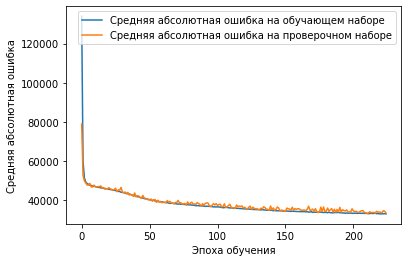

In [54]:
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

## Готовим данные для теста на liderboard

Делаем предсказания на тестовом наборе данных

In [55]:
"""делаем предсказания по всем тестовым данным"""
predictions = model.predict(x_test)
predictions

array([[ 54584.395],
       [ 60270.293],
       [ 69190.516],
       ...,
       [298747.94 ],
       [ 63286.477],
       [ 70694.21 ]], dtype=float32)

Пишем результаты предсказаний в шаблон "sample_submission"

In [56]:
"""используем файл с правильным шаблоном формата записи ответов и пишем в него наши предсказания"""
sample_submission['median_house_value'] = predictions

Записываем ответы для проверки на liderboard

In [57]:
"""to_csv - пишет табличные данные в файл '.csv' """
sample_submission.to_csv('sample_submission.csv')